# Landscape inference from counts data: SeqDEFT

Many times, rather than quantitative measurements of a phenotype or trait for a large collection of sequences we just can count how many times we observe a particular sequence, e.g. the number of times a 5' splice site appears in the human transcriptome or the number of times a particular combination of chromosomal abnormalities are observed in tumors (See [Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118) for more details). 

In this case, we are interested in estimating the density or probability of each of the possible sequences using only a finite and typically small number of observations, that can range from hundreds to thousands.

If two positions are independent, then the probability of observing a particular combination at 2 sites is equal to the product of the individual probabilities. 

$$p(AB) = p(A) p(B)$$

In other words, the log-probabilities are additive.

$$log(p(AB)) = log(p(A)) + log(p(B))$$

Thus, we can apply models that minimize the magnitude of the deviations in a field $\Phi$ from the additive, pairwise, or in general, any $P$-order model, that are most compatible with the observed genotypic counts.

$$Q_i = \frac{e^{-\Phi_i}}{\sum_j e^{-\Phi_j}}$$

where the field is just a shifted version of the $\log Q$:

$$\log Q_i = -\Phi_i - \log\left({\sum_j e^{-\Phi_j}}\right)$$

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import gpmap.src.plot as plot
import gpmap.src.inference as inf

from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWSWalk

from scipy.special._logsumexp import logsumexp
from scipy.stats.stats import pearsonr

### Inference from simulated data

For illustration purposes, lets first a simulate a mostly additive landscape, with exponentially decreasing contributions of higher order interactions using Variance Component regression

In [2]:
np.random.seed(1)
seq_length = 5
n_alleles = 4
lambdas = [0] + [10**(3-i) for i in range(seq_length)]

vc = inf.VCregression()
vc.init(seq_length=seq_length, n_alleles=n_alleles)
phi = vc.simulate(lambdas)['y']

We will assume that the simulated values are the $\Phi$ values for each sequence and then sample a small number of observations from the resulting probability distribution and show the values for some of the sequences. Note that most of the sequence are not even observed once when sampling only 1000 sequences

In [3]:
n_seqs = 1000
Q_real = np.exp(phi - logsumexp(phi)) 
counts = np.random.multinomial(n=n_seqs, pvals=Q_real)
data = pd.DataFrame({'Q_real': Q_real, 'counts': counts}, index=vc.genotypes)
print("% of possible genotypes observed at least once: {:.2f}".format((data['counts'] > 0).mean() * 100))

% of possible genotypes observed at least once: 7.03


Note that there are we have observed only a few sequences at least one time and actually most of the sequences have not even been observed a single time. While this evidences that their probability is probably lower than the highly observed sequences, there is still a wide range of variability in the sequence probability density below the observable threshold that we may be able to infer by sharing information across sequence space.

We can now define a SeqDEFT model with a specific value of $P$, such that we are minimizing the deviations from a $P-1$ order model across all $P$-faces of the Hamming hypercube. Thus, for $P=2$, we are minimizing the local deviations from a simple additive model or penalizing in the posterior these deviations. 

In [4]:
model = inf.SeqDEFT(P=2)

The strength of this penalization is given by the hyperparameter $a$, which we optimize using cross-validation and selecting the $a^*$ with the highest log-likelihood in held out data. In practice, we need to define a finite series of $a$ values, which we know interpolate between the maximum entropy solution of order $P$ (where all these deviations are exactly 0) and the observed empirical frequencies for each of the sequences, which are subject to sampling noise. Thus, in practice, we are smoothing the $\log Q$ over sequence space, where $a*$ indicates the degree of the smoothing between these two extreme cases. 

Thus, we generate a geometrically spaced series of $a$ values between a minimal $a$ value that is very close to the empirical frequencies and maximum $a$ value that is very close to the maximum entropy solution, assuming that the best solution will be somewhere in the middle, with some contribution of the local deviations from the $P-1$th order model. 

In [5]:
inferred = model.fit(X=data.index.values, counts=data['counts'].values, num_a=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.06s/it]


We can see that even for a small example of 5 nucleotides long sequence spanning only $4^5=1024$ possible genotypes, iterating through all the cross-validation folds for each $a$ value takes a substatial amount of time. For larger genotypic spaces, however, one could paralellize these calculations by defining the training and testing datasets for the cross-validation and fit the model with different $a$ values at the same time.

Lets see how the log-likelihood in held-out data evolves with the different values of the hyperparameter $a$ tested.

In [6]:
model.log_Ls

a  log_likelihood_mean  log_likelihood_sd
0       0.023040          -636.199998          47.146323
1       0.138121          -627.274178          43.325152
2       0.828015          -619.795292          40.622326
3       4.963818          -611.267616          37.047837
4      29.757304          -604.462256          34.021436
5     178.390352          -602.724644          30.930983
6    1069.422067          -614.985824          29.210624
7    6411.016863          -646.624986          27.825119
8   38433.036377          -694.448354          28.640641
9  230400.000000          -720.040647          25.880938

In [7]:
fig = plot.plot_SeqDEFT_summary(model.log_Ls, inferred)

 We can see that the optimal value $a^*$ is far from 0 but also is not $\infty$ either, showing that the optimal solution is indeed somewhere in between the maximum entropy solution and the empirical frequencies. 

The second plot shows the relationship between the observed frequencies in the data and the inferred densities for each of the genotypes. For high frequencies, we generally see a very good agreement between the observed frequencies and inferred densities, but as we start to have lower number of counts per sequences, we can see how the prior becomes more and more important. Indeed, the sequences with lowest frequency, those observed only once, show substantial variability, of about one order of magnitude, in the inferred densities thanks to our ability to share information across neighboring sequences and smooth the log-densities over sequence space. 

In this case, as the data was simulated, we can see good our estimates of the sequence density were by comparing with the true data generating probabilities

In [10]:
data = data.join(inferred)
data.head()

Q_real  counts  frequency        Q_star
AAAAA  3.661469e-06       0        0.0  5.234807e-06
AAAAB  5.151412e-09       0        0.0  3.646003e-07
AAAAC  4.113687e-06       0        0.0  3.199305e-06
AAAAD  1.991108e-09       0        0.0  2.762689e-06
AAABA  5.894597e-07       0        0.0  7.804429e-06

(0.7491998381529368, 4.6734753440450473e-185)

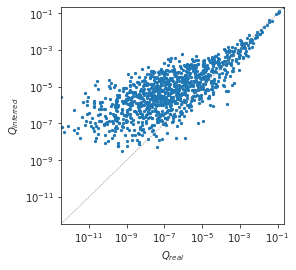

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

Q = data[['Q_real', 'Q_star']].values.flatten()
lims = (Q.min(), Q.max())
axes.scatter(data['Q_real'], data['Q_star'], s=5)
axes.plot(lims, lims, lw=0.5, linestyle='--', c='grey')
axes.set(xlabel=r'$Q_{real}$', ylabel=r'$Q_{inferred}$', xscale='log', yscale='log',
         xlim=lims, ylim=lims)
pearsonr(np.log(data['Q_real']), np.log(data['Q_star']))

We can see that even for sequences with low density, such that they  would almost never be observed in practice by sampling only 1000 genotypes from this distribution, SeqDEFT provides a moderately good estimate of the sequence density. While it tends to overestimate the density of very rare sequences, it still provides a good idea of which sequences have higher or lower probability.

### Visualizing sequence densities

But maybe a more important issue rather than the precission with which we can estimate the sequence probability is whether we are able to recover the main qualitative features of the original landscape from the simulated data. Thus, we can compare the visualizations for both the real and the estimated $\log Q$ as follows:

In [16]:
space_real = SequenceSpace(X=inferred.index.values, y=np.log10(data['Q_real']))
space_inferred = SequenceSpace(X=inferred.index.values, y=np.log10(data['Q_star']))
spaces = {'real': space_real, 'inferred': space_inferred}

When trying to visualize densities rather than an arbitrary function or phenotype over sequence space, it provides a very natural way of setting the hyperparameter ``Ns``, since we can assume that the observed densities correspond to the stationary frequencies under our evolutionary model. As we saw previously, the stationary frequencies are given by:

$$\pi_i = \frac{e^{Ns f_i}}{\sum_j e^{Ns f_j}}$$

Thus, if we assume that $f_i = \log Q_i$, then we can choose ``Ns=1`` and:

$$\pi_i = \frac{e^{\log Q_i}}{\sum_j e^{\log Q_j}} = Q_i$$


In [29]:
viz = {}
for label, space in spaces.items():
    rw = WMWSWalk(space)
    rw.calc_visualization(Ns=1, n_components=5)
    nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()
    viz[label] = nodes_df, edges_df

In [30]:
fig, subplots = plot.init_fig(1, len(spaces), colsize=5.5, rowsize=5)

for axes, (label, (nodes_df, edges_df)) in zip(subplots, viz.items()):
    plot.plot_visualization(axes, nodes_df, edges_df=edges_df, nodes_size=10)
    axes.set_title('{} landscape'.format(label.capitalize()))

fig.tight_layout()

It seems that the structure of the two landscapes is similar, but it is unclear from the plots whether the most separated set of sequences are the same in the two plots. We can instead show how the coordinates in the different diffusion axis correlate across the two embeddings

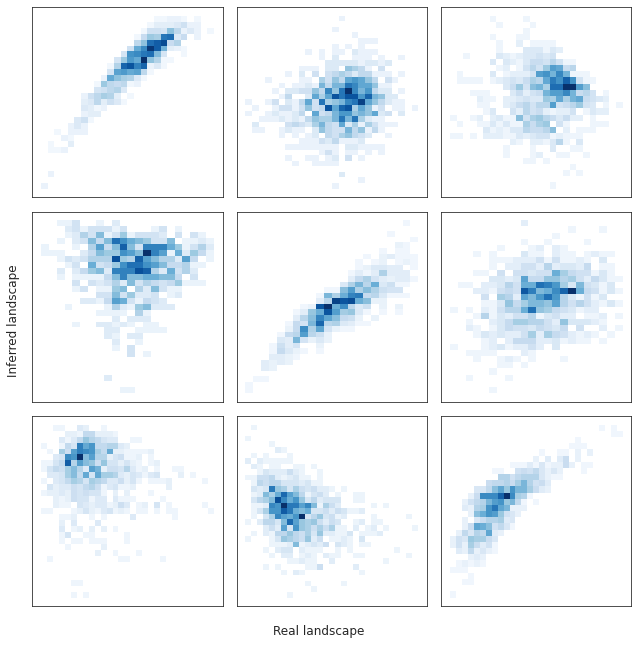

In [37]:
fig, subplots = plot.init_fig(3, 3, colsize=3, rowsize=3)

for i in range(3):
    for j in range(3):
        axes = subplots[i, j]
        x, y = viz['real'][0][str(i+1)].values, viz['inferred'][0][str(j+1)].values
        sns.histplot(x=x, y=y, cmap='Blues', ax=axes)
        axes.set(xlabel='', ylabel='', xticks=[], yticks=[])

fig.supxlabel('Real landscape')
fig.supylabel('Inferred landscape')
fig.tight_layout()

Thus, we can see that the main structure is preserved, with a very good correlation in the coordinates of the main diffusion axes between the real and inferred sequence densities.